In [1]:
from __future__ import print_function, division
%run basics.ipynb

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

Using Theano backend.


In [2]:
df_tags = pd.read_csv('../coursera/data/ds_urls_shortnames_concepts_reviewed_2016_06_21.csv', encoding='utf-8')
print('len:', len(df_tags))
print('tags count:', df_tags['concept_tag'].count())
df_tags.head(2)

len: 940
tags count: 940


,id,course_shortname,url,concept_tag
0,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,video_lecture
1,ud257,ab-testing,https://www.udacity.com/course/ab-testing--ud2...,in_depth


In [3]:
df = pd.read_csv('../coursera/data/learning_resource_table_2016_07_05.csv')
df = pd.read_csv('../coursera/data/learning_resource_w_slide_transcript_2016_07_07.csv')
print('len:', len(df))
df.head(2)

len: 357


,id,title,subtitle,description,short_description,venue,slide_text,transcript_text
0,cs101,Intro to Computer Science,Build a Search Engine & a Social Network,In this introduction to computer programming c...,Learn key computer science concepts in this in...,Udacity,NaN,NaN
1,ud257,A/B Testing,Online Experiment Design and Analysis,This course will cover the design and analysis...,This course will cover the design and analysis...,Udacity,NaN,NaN


In [4]:
df = pd.merge(df_tags, df, on='id', how='outer').groupby(by='id', as_index=False)
merged_df = pd.DataFrame(df.apply(lambda x: x.iloc[0]))
merged_df['tags'] = df.apply(lambda x: map(str, list(x['concept_tag'].values)))
print('len:', len(merged_df))
print(merged_df.columns)
merged_df.head(2)

len: 357
Index([               u'id',  u'course_shortname',               u'url',
             u'concept_tag',             u'title',          u'subtitle',
             u'description', u'short_description',             u'venue',
              u'slide_text',   u'transcript_text',              u'tags'],
      dtype='object')


,id,course_shortname,url,concept_tag,title,subtitle,description,short_description,venue,slide_text,transcript_text,tags
0,-4ffSHNYEeWIfhKr_WcYsQ,reproducible-res,http://www.coursera.org/learn/reproducible-res...,reproducibility,Reproducible Research,NaN,This course focuses on the concepts and tools ...,NaN,Coursera,NaN,NaN,"[reproducibility, project, R, in_depth, video_..."
1,-N44X0IJEeWpogr5ZO8qxQ,ml-clust-retrieve,http://www.coursera.org/learn/ml-clustering-an...,natural_language_processing,Machine Learning: Clustering & Retrieval,NaN,Case Studies: Finding Similar Documents\n\nA r...,NaN,Coursera,NaN,NaN,"[natural_language_processing, text_data, high_..."


In [5]:
merged_df.isnull().sum()/len(merged_df)

id                   0.000000
course_shortname     0.585434
url                  0.585434
concept_tag          0.585434
title                0.000000
subtitle             0.952381
description          0.187675
short_description    0.952381
venue                0.000000
slide_text           0.478992
transcript_text      0.537815
tags                 0.000000
dtype: float64

In [6]:
df = merged_df
#df['all-text'] = df['title'] + ' ' + df['subtitle'] + ' ' + df['description'] + ' ' + df['short_description'] + ' ' + df['syllabus']
cols = ['title', 'description', 'slide_text', 'transcript_text']
df['all-text'] = ''
for i in cols:
    df['all-text'] += df[i].astype('str')
    df['all-text'] += ' '
df['all-text'].tail(10)

347    Neural Networks for Machine Learning Learn abo...
348    Statistical Reasoning for Public Health 1: Est...
349    Mining Massive Datasets This class teaches alg...
350    Artificial Intelligence Planning The course ai...
351    Computational Methods for Data Analysis <div>E...
352    Relational Database Support for Data Warehouse...
353    Marketing Analytics Organizations large and sm...
354    People Analytics People analytics is a data-dr...
355    Data Warehouse Concepts, Design, and Data Inte...
356    Data Manipulation at Scale: Systems and Algori...
Name: all-text, dtype: object

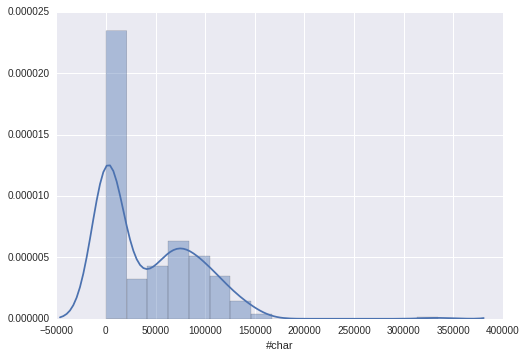

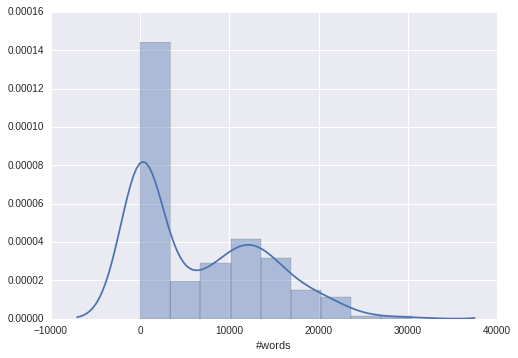

In [7]:
sns.distplot(df['all-text'].apply(len))
plt.xlabel('#char')
plt.show()
sns.distplot(df['all-text'].apply(lambda x: len(x.split())))
plt.xlabel('#words')
plt.show()

In [8]:
df['all-text'] = df['all-text'].apply(text_cleanup)
len(df)

357

<type 'numpy.ndarray'>
(357, 12488)
2


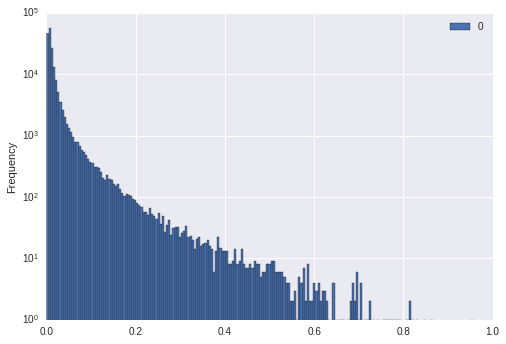

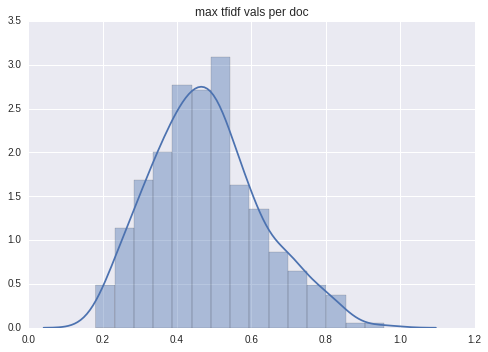

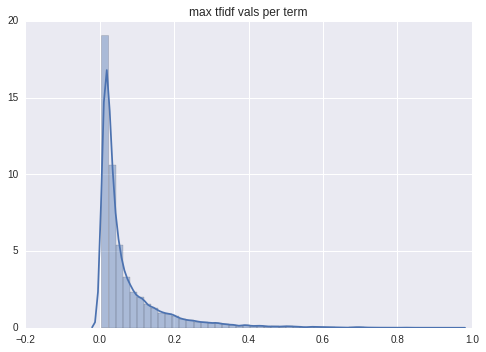

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.3, min_df=3, ngram_range=(1, 1))
vectorized_text = vectorizer.fit_transform(df['all-text'].values)
from sklearn.decomposition import TruncatedSVD
if False:
    svd = TruncatedSVD(n_components=50, n_iter=100)
    vectorized_text = svd.fit_transform(vectorized_text)
else:
    vectorized_text = np.array(vectorized_text.todense())
print(type(vectorized_text))
print(vectorized_text.shape)
print(len(vectorized_text.shape))
plot_tfidf_vals(vectorized_text)

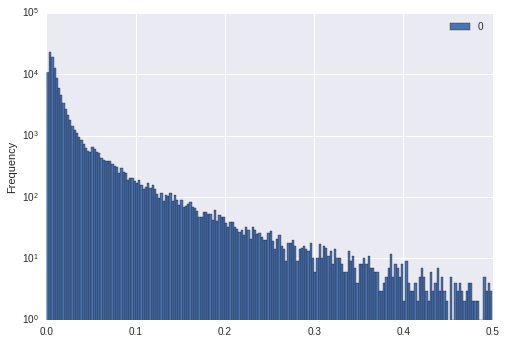

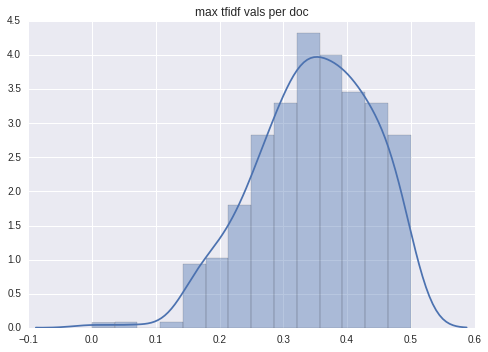

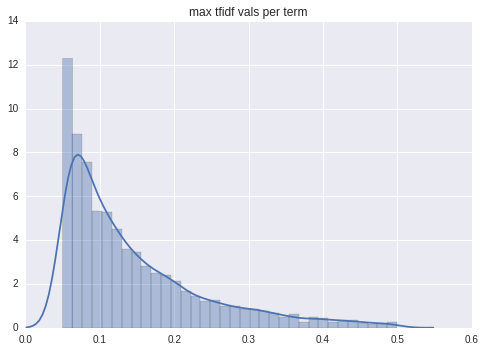

(357, 4684)
[u'ofthe' u'segmentation' u'songs' u'track' u'electronic' u'rely' u'sweet'
 u'brief' u'satisfiability' u'explored']


In [11]:
tfidf, words = filter_tfidf_max(vectorized_text, vectorizer.get_feature_names(), min_th=.05, max_th=.5)
plot_tfidf_vals(tfidf)
print(tfidf.shape)
print(np.random.choice(words, size=10))

In [12]:
diffs = list()
for idx in tqdm(range(vectorized_text.shape[0]), position=0):
    for jdx in range(vectorized_text.shape[0]):
        v1 = vectorized_text[idx, :].copy()
        v2 = vectorized_text[jdx, :].copy()
        
        th = .2
        cons_idx = (v2 - th > v1) & (v1 > 0.)
        v1 = v1[cons_idx]
        v2 = v2[cons_idx]
        
        diff = (v2 - v1).sum()
        diffs.append((idx, jdx, diff))

100%|██████████| 357/357 [00:13<00:00, 27.91it/s]


In [13]:
diff_df = pd.DataFrame(columns=['idx', 'jdx', 'diff'], data=diffs)
diff_df['c1'] = map(lambda x: df.iloc[x]['title'], diff_df['idx'])
diff_df['c2'] = map(lambda x: df.iloc[x]['title'], diff_df['jdx'])
diff_df.sort_values(by='diff', inplace=True, ascending=False)

In [14]:
print(diff_df['diff'].min())
print(diff_df['diff'].max())
diff_df.head(100)

0.0
2.55506534982


,idx,jdx,diff,c1,c2
18546,51,339,2.555065,Bayesian Inference - VideoLectures.NET,Statistics: Making Sense of Data
52079,145,314,2.367556,Scale-out Beyond MapReduce - VideoLectures.NET,Process Mining: Data science in Action
41369,115,314,2.259705,Data Mining for Anomaly Detection - VideoLectu...,Process Mining: Data science in Action
56382,157,333,2.252120,Understanding and Managing Cascades on Large G...,Applied Regression Analysis
60309,168,333,2.198088,"Bringing Structure to Text: Mining Phrases, En...",Applied Regression Analysis
18540,51,333,2.181874,Bayesian Inference - VideoLectures.NET,Applied Regression Analysis
75637,211,310,2.164032,Data analytics involving text - VideoLectures.NET,Introduction to Natural Language Processing
52098,145,333,2.161727,Scale-out Beyond MapReduce - VideoLectures.NET,Applied Regression Analysis
18551,51,344,2.114886,Bayesian Inference - VideoLectures.NET,Natural Language Processing
79598,222,344,2.108632,Scaling Up Deep Learning - VideoLectures.NET,Natural Language Processing


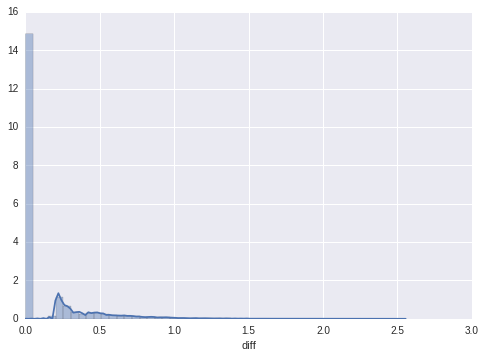

In [15]:
sns.distplot(diff_df['diff'])
plt.show()

In [16]:
def filter_top_prereq(df):
    s_df = df.sort_values(by='diff', ascending=True)
    return s_df[s_df['diff']>0.1].copy().iloc[-2:]
    #return s_df.iloc[-3:]

prereq = pd.DataFrame(diff_df.groupby(by='c1').apply(filter_top_prereq))[['diff', 'c2']]
prereq

diff  \
c1                                                                    
 Kernel methods and Support Vector Machines - V... 30669   1.578984   
                                                   30385   1.586275   
 Large-scale Data Mining: MapReduce and Beyond ... 47390   1.398760   
                                                   47438   1.407382   
A Crash Course in Data Science                     91157   0.386361   
                                                   91253   0.607070   
A Data Scientist’s Guide to Making Money from S... 58562   1.097600   
                                                   58872   1.572671   
A framework for pattern analysis - VideoLecture... 48187   0.904623   
                                                   48178   1.171499   
A/B Testing                                        105950  0.484506   
                                                   105909  0.505480   
Accounting Analytics                               100584  0.634554   
                                                   100544  0.652780   
Active Learning - VideoLectures.NET                47815   1.257698   
                                                   47570   1.452049   
Advances in Structured Prediction - VideoLectur... 4237    0.812492   
                                                   4271    1.002161   
Adversarial Examples - VideoLectures.NET           78352   0.769585   
                                                   78249   0.855535   
Adversarial bandit problems: the power of rando... 32897   0.734555   
                                                   33158   1.230119   
Algorithms for DNA Sequencing                      84088   0.322501   
                                                   84142   0.571701   
Algorithms for Interpretable Machine Learning -... 64573   1.421605   
                                                   64582   1.658053   
Algorithms for Predicting Structured Data - Vid... 61900   1.631960   
                                                   62071   1.742305   
An Introduction to Statistical Relational Learn... 35310   1.368342   
                                                   35330   1.421722   
...                                                             ...   
Tutorial on Neural Network Optimization Problem... 7029    0.813145   
                                                   6909    0.970817   
Tutorial on Statistical Machine Learning with A... 52455   1.277436   
                                                   52446   1.644954   
Understanding China, 1700-2000: A Data Analytic... 120801  0.409263   
                                                   121006  0.556809   
Understanding Clinical Research: Behind the Sta... 101315  0.262586   
                                                   101312  0.476942   
Understanding and Managing Cascades on Large Gr... 56390   1.868687   
                                                   56382   2.252120   
Undirected Graphical Models - VideoLectures.NET    12615   1.233091   
                                                   12621   1.398261   
Unsupervised learning - VideoLectures.NET          49945   1.422614   
                                                   49967   1.752910   
Using Databases with Python                        96343   0.777346   
                                                   96377   0.967015   
Variational Autoencoder and Extensions - VideoL... 50463   1.181839   
                                                   50457   1.322587   
Visual features II - VideoLectures.NET             11533   0.543075   
                                                   11484   0.565571   
Visual features: From Fourier to Gabor - VideoL... 39111   0.362639   
                                                   38947   0.453948   
Vowpal Wabbit - VideoLectures.NET                  44334   0.851887   
                                                   44563   0.919145   
Web Intelligence

In [ ]:
pd.unique(prereq['c1'])

In [ ]:
prereq[prereq['c1'] == 'Machine Learning Capstone: An Intelligent Application with Deep Learning']

In [ ]:
df[df['title'] == 'Operations Analytics']['description'].values